## Accessing the data and simple stats of the emails

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('messages.csv')

print(f"Number of email threads {len(df)}")
df.describe()

Number of email threads 833


,Path,FileName,From,To,Sent,Subject,Content
count,833,833,833,833,833,678,828
unique,833,792,126,192,682,126,708
top,pdfs/kronprinsessen/EFTA00646552.pdf,EFTA01764058.pdf,H.K.H. Kronprinsessen,Jeffrey Epstein <jeevacation@gmail.com>,2012-12-28T14:15:35+00:00,Re:,Jeff Island ?
freq,1,2,152,161,6,346,5


## Cleaning up To and From fields
These kinds of people are notorious for using various aliases and different emails.
This code attempts to consolidate all emails to their known aliases, in addition to reduce parsing errors.

In [3]:

known_people = {
    'boris' : "Boris Nikolic", 
    'jeff' : "Jeffrey Epstein",
    'kpm' : "H.K.H. Kronprinsessen",
    'kronprinsessen' : "H.K.H. Kronprinsessen",
    'casanova' : "Gerry Casanova",
    'lesley' : "Lesley Groff",
}

def is_known(name):
    for alias in known_people.keys():
        if alias in name:
            return alias
    return ""

for i, row in df.iterrows():
    sender = row['From'].replace("\"", "")
    recipient = row['To'].replace("\"", "")
    if is_known(sender.lower()) != "":
        df.loc[i, 'From'] = known_people[is_known(sender.lower())]
    if is_known(recipient.lower()) != "":
        df.loc[i, 'To'] = known_people[is_known(recipient.lower())]

df[['From', 'To']]

,From,To
0,H.K.H. Kronprinsessen,Jeffrey Epstein
1,H.K.H. Kronprinsessen,Jeffrey Epstein
2,H.K.H. Kronprinsessen,Jeffrey Epstein
3,H.K.H. Kronprinsessen,Jeffrey Epstein
4,H.K.H. Kronprinsessen,Jeffrey Epstein
...,...,...
828,Boris Nikoli,Jeffrey Epstein
829,Jeffrey Epstein,Boris Nikoli
830,Gerry Casanova,Jeffrey Epstein
831,Gerry Casanova,Jeffrey Epstein


## Cleaning up the dates and creating a timeline of emails

In [4]:

df.loc[0, 'Sent'] = str(datetime(2012, 12, 10))
df['Sent'] = pd.to_datetime(df['Sent'], format='mixed', utc=True)
for i, row in df.iterrows():
    date = row['Sent']
    if date.year == 2026 or date.year == 2002: # Remove Outliers
        df.loc[i, 'Sent'] = pd.Timestamp('NaT') # These dates are wrongly parsed so set them to NaT
df['Sent']

0     2012-12-10 00:00:00+00:00
1                           NaT
2                           NaT
3                           NaT
4                           NaT
                 ...           
828   2011-05-10 18:56:00+00:00
829   2011-05-10 03:01:00+00:00
830   2009-05-13 22:17:25+00:00
831   2009-05-13 22:17:25+00:00
832                         NaT
Name: Sent, Length: 833, dtype: datetime64[us, UTC]

In [5]:
first = min(df['Sent'])
last = max(df['Sent'])
print(first, last)

2009-05-13 22:17:25+00:00 2020-07-22 10:32:13+00:00


[2, 0, 75, 318, 348, 61, 0, 0, 2, 3, 15, 2]


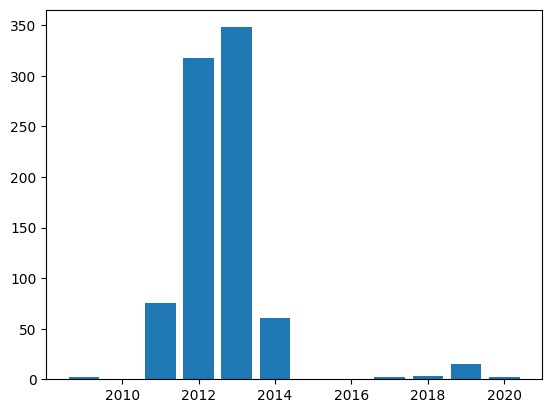

In [6]:
time_line = []
counts = []
for year in range(first.year, last.year + 1):
    time_line.append(year)
    counts.append(0)


for i, corr in df.iterrows():
    if pd.isna(corr['Sent']):
        continue
    index = corr['Sent'].year - first.year
    counts[index] += 1

print(counts)
plt.bar(time_line, counts)
plt.show()

In [7]:
import re

filler_words = ["sendt","wrote", "h", "kl", "b", "c", "y", "de", "o", "u", "f", "june", "propertylist", "label", "z", "la", "sg", "j", "f", "t", "q","g","n", "encoding", "utf", "let", "doctype", "tue", ";", "d", "array", "dtd", "efta_r1_01", "apple", "date", "l","en", "id","string", "d" "y", "le", "x", "00pm", "w", "je", "re","s", "ce", "m", "p", "e", "kl.", "oct", "okt", "cc", "version", "xml", "version", "des", "tue", "thu", "mon", "dict", "den", "dec", "plist", "wed", "sun", "fri", "sat", "pm", "jan", "<jeevacation@gmail.com>:", "<jccvacationagmail.com>", "<mailto:jeevacation@gmail.com»:", "<jeevacation@gmail.com", "feb", "mar", "apr", "key", "integer", "sep", "mai", "jun", "jul", "aug", "nov" "des",  "skrev", "gmail", "mailto", "subject", "sent", "sendt", "jeevacation"]

def filter_text(text, words):
    return " ".join(
        w for w in re.findall(r"\b\w+\b", text)
        if w.lower() not in words
    )

all_content = ""
for i, row in df.iterrows():
    mail_content = str(row['Content'])
    filtered = filter_text(mail_content, [w.lower() for w in filler_words])
    all_content += filtered



# Creating a Wordcloud of all Email Content
The following snippet creates a wordcloud of all the email contents. Unsuprisingly names are the most common words

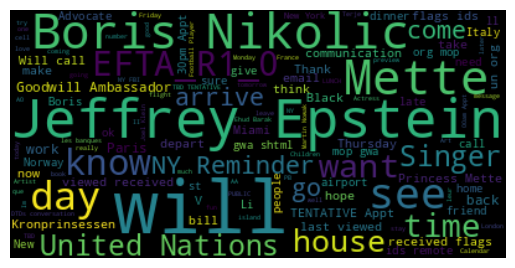

In [8]:
wordcloud = WordCloud().generate(all_content)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Displaying email content

In [9]:
def print_email(i):
    print("===============================")
    print(f"From: {df.loc[i, 'From']}")
    print(f"To: {df.loc[i, 'To']}")
    print(f"Subject: {df.loc[i, 'Subject']}  Date: {df.loc[i, 'Sent']}")
    print()
    print(df.loc[i, 'Content'])
    print("===============================")
print_email(0)

From: H.K.H. Kronprinsessen
To: Jeffrey Epstein
Subject: Re:  Date: 2012-12-10 00:00:00+00:00

 Called u today


In [10]:
for i, row in df.iterrows():
    subject = row['Subject']
    if not pd.isna(subject) and len(subject) > 3:
        print_email(i)

From: H.K.H. Kronprinsessen
To: Jeffrey Epstein
Subject: Re: Thank you  Date: NaT

 Yes there are. Where are you?
From: H.K.H. Kronprinsessen
To: Jeffrey Epstein
Subject: Re: Re: Re: Re: Re:  Date: NaT

 Every day is a constant struggle of scratching the soul just Enough to still be able to chose the light
From: Bulletin Intelligence
To: FBI@BulletinIntelligence.com
Subject: FW: [EXTERNAL EMAIL] - FBI Public Affairs News Briefing Wednesday, July  Date: 2020-07-22 10:32:13+00:00

 Subject: [EXTERNAL EMAIL] - FBI Public Affairs News Briefing Wednesday, July 22, 2020 Mobile version and searchable archives available at fbi.bulletinintelligence.com. FBI News Briefing TO: THE DIRECTOR AND SENIOR STAFF DATE: WEDNESDAY, JULY 22, 2020 6:30 AM EDT TODAY'S TABLE OF CONTENTS LEADING THE NEWS • FBI Arrests Ohio House Speaker In Corruption Probe. PROTESTS • ABC News/Washington Post Poll: Most Oppose Defunding Police, Removing Statues. • White House Calls Prosecution Of McCloskeys "Extreme Abuse Of P

## Exporting CSV based on senders

In [18]:
def all_correspondence(p1, p2):
    q = f"(From == '{p1}' and To == '{p2}') or (From == '{p1}' and To == '{p2}')"
    return df.query(q)

kmp_jeff = all_correspondence('Jeffrey Epstein', 'H.K.H. Kronprinsessen')
lg_jeff = all_correspondence('Jeffrey Epstein', 'Lesley Groff')
bor_jeff = all_correspondence('Boris Nikolic', 'Jeffrey Epstein')
bor_kmp = all_correspondence('Boris Nikolic', 'H.K.H. Kronprinsessen')
lg_kmp = all_correspondence('Lesley Groff', 'H.K.H. Kronprinsessen')

kmp_jeff.to_csv('mette_jeff.csv')
bor_kmp.to_csv('boris_mette.csv')
bor_jeff.to_csv('boris_jeff.csv


,Path,FileName,From,To,Sent,Subject,Content
32,pdfs/kronprinsessen/EFTA00991747.pdf,EFTA00991747.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2014-06-23 10:07:37+00:00,NaN,??9
33,pdfs/kronprinsessen/EFTA00992209.pdf,EFTA00992209.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2014-06-21 02:05:41+00:00,NaN,we didn't finish conversation
35,pdfs/kronprinsessen/EFTA01919221.pdf,EFTA01919221.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2014-06-16 10:27:38+00:00,Re:,plate send number
37,pdfs/kronprinsessen/EFTA01921617.pdf,EFTA01921617.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2014-06-15 21:00:04+00:00,Re:,"Ok On Sunday, June 15, 2014, H.K.H. Kronprins..."
40,pdfs/kronprinsessen/EFTA00991191.pdf,EFTA00991191.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2014-06-14 11:08:44+00:00,NaN,"didn;t get to see you, ?"
...,...,...,...,...,...,...,...
813,pdfs/kronprinsessen/EFTA00922801.pdf,EFTA00922801.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2011-10-24 14:40:29+00:00,Re: Re: Re: Re:,they can scratch in itch in your soul„ or cre...
816,pdfs/kronprinsessen/EFTA00922796.pdf,EFTA00922796.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2011-10-24 13:43:14+00:00,Re: Re: Re:,"i hope that you understand that ""what and why..."
817,pdfs/kronprinsessen/EFTA01994170.pdf,EFTA01994170.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2011-10-24 13:43:14+00:00,Re: Re: Re:,EFTA_R1_00488063 EFTA01994170
820,pdfs/kronprinsessen/EFTA01772997.pdf,EFTA01772997.pdf,Jeffrey Epstein,H.K.H. Kronprinsessen,2011-10-24 06:27:00+00:00,Re: Re:,Sweetness is a better translation ..thanks Se...
